In [128]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [129]:
# Initial CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [67]:
class TinyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(8 * 12 * 12, 10)  # after 28 → 24 (conv) → 12 (pool)

    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [68]:
# model = TinyCNN().to(device)
model = SimpleCNN().to(device)

In [143]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [144]:
# Train the model
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
        _, predicted = output.max(1)
        correct += (predicted == target).sum().item()
        total += target.size(0)
        
    # print(f"Epoch {epoch} complete")
    avg_loss = running_loss / total
    accuracy = correct / total
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}")

Epoch 1 | Loss: 0.0063 | Accuracy: 0.9979
Epoch 2 | Loss: 0.0024 | Accuracy: 0.9992
Epoch 3 | Loss: 0.0033 | Accuracy: 0.9988
Epoch 4 | Loss: 0.0044 | Accuracy: 0.9983
Epoch 5 | Loss: 0.0025 | Accuracy: 0.9992


In [132]:
def test(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    acc = correct / len(loader.dataset)
    print(f'Test accuracy: {acc:.4f}')

test(model, test_loader)

Test accuracy: 0.9899


In [72]:
def create_adversarial_image(model, image, target_class, epsilon= 0.8):
    model.eval()
    image.requires_grad = True

    output = model(image)
    loss = F.cross_entropy(output, torch.tensor([target_class]).to(device))

    model.zero_grad()
    loss.backward()
    perturbation = epsilon * image.grad.sign()
    adversarial_image = image + perturbation
    adversarial_image = torch.clamp(adversarial_image, 0, 1)
    return adversarial_image

In [73]:
def create_adversarial_image_pgd(model, image, target_class, epsilon=0.8, alpha=0.05, num_steps=10):
    model.eval()
    original_image = image.clone().detach()
    adv_image = image.clone().detach().requires_grad_(True)

    for step in range(num_steps):
        output = model(adv_image)
        loss = F.cross_entropy(output, torch.tensor([target_class]).to(device))

        model.zero_grad()
        loss.backward()

        # Take a small step in the direction of the gradient
        with torch.no_grad():
            adv_image += alpha * adv_image.grad.sign()

            # Project the perturbation back to the epsilon ball
            perturbation = torch.clamp(adv_image - original_image, min=-epsilon, max=epsilon)
            adv_image = torch.clamp(original_image + perturbation, 0, 1).detach()
            adv_image.requires_grad = True  # re-enable gradient

    return adv_image

In [133]:
# Pick a '4' from test set
for img, label in test_dataset:
    if label == 4:
        original_img = img.unsqueeze(0).to(device)
        break
# rand_index = np.random.randint(0, len(index_of_4s))
# image_norm = mnist.test.images[index_of_2s[rand_index]]
# image_norm = np.reshape(original_img, (1, 784))
# label_adv = [0,0,0,0,0,0,0,0,0,1] # one hot encoded, adversarial label 6


Original Prediction: 4
Logits: [[-17.989887  -11.684252   -3.8790817 -30.59779    31.619755  -20.244537
   -9.513711  -18.549603   -4.7809453 -57.366684 ]]
Prediction: 4
Prediction after adversarial attack: 4


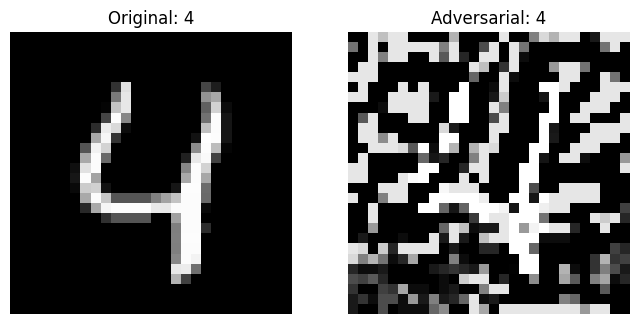

In [98]:
# # Pick a '4' from test set
# for img, label in test_dataset:
#     if label == 4:
#         original_img = img.unsqueeze(0).to(device)
#         break

# Check the original prediction
model.eval()
pred_orig = model(original_img).argmax(dim=1).item()
print(f'Original Prediction: {pred_orig}')

# Create adversarial image targeting '9'
target_class = 9
adv_img = create_adversarial_image_pgd(model, original_img, target_class, epsilon = 0.9, num_steps=50)

# Check new prediction
pred_adv = model(adv_img)
print("Logits:", pred_adv.detach().cpu().numpy())
print("Prediction:", pred_adv.argmax(dim=1).item())
print(f'Prediction after adversarial attack: {pred_adv.argmax(dim=1).item()}')

# Plot
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title(f'Original: {pred_orig}')
# plt.imshow(original_img.squeeze().cpu().numpy(), cmap='gray')
plt.imshow(original_img.squeeze().detach().cpu().numpy(), cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title(f'Adversarial: {pred_adv.argmax(dim=1).item()}')
plt.imshow(adv_img.squeeze().detach().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()


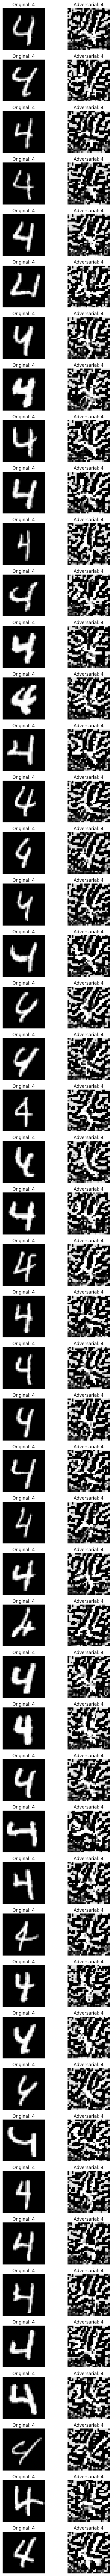

In [76]:
num_examples = 50  # how many examples you want to create

original_images = []
adversarial_images = []
original_preds = []
adversarial_preds = []

count = 0

# Find '4's in the test set
for img, label in test_dataset:
    if label == 4:
        img = img.unsqueeze(0).to(device)
        
        # Original prediction
        pred_orig = model(img).argmax(dim=1).item()
        
        # Create adversarial image targeting '9'
        adv_img = create_adversarial_image_pgd(model, img, target_class=9, epsilon = 0.9, num_steps=40)
        
        # Adversarial prediction
        pred_adv = model(adv_img).argmax(dim=1).item()
        
        # Store for plotting
        original_images.append(img.squeeze().detach().cpu())
        adversarial_images.append(adv_img.squeeze().detach().cpu())
        original_preds.append(pred_orig)
        adversarial_preds.append(pred_adv)
        
        count += 1
        if count == num_examples:
            break

# Plotting
fig, axs = plt.subplots(num_examples, 2, figsize=(6, 2 * num_examples))

for i in range(num_examples):
    # Original
    axs[i, 0].imshow(original_images[i].numpy(), cmap='gray')
    axs[i, 0].set_title(f'Original: {original_preds[i]}')
    axs[i, 0].axis('off')
    
    # Adversarial
    axs[i, 1].imshow(adversarial_images[i].numpy(), cmap='gray')
    axs[i, 1].set_title(f'Adversarial: {adversarial_preds[i]}')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


In [119]:
def plot_predictions(model, images, return_probs=False, adversarial=False):

    model.eval()
    # Ensure images are a batch of shape (N, 1, 28, 28)
    if isinstance(images, np.ndarray):
        images_tensor = torch.from_numpy(images).float()
    else:
        images_tensor = images.clone().detach().float()
    if images_tensor.dim() == 3:
        images_tensor = images_tensor.unsqueeze(1)  # make batch of 1 if needed
    images_tensor = images_tensor.to(next(model.parameters()).device)

    # Get model predictions (probabilities)
    with torch.no_grad():
        logits = model(images_tensor)
        probs = F.softmax(logits, dim=1).cpu().numpy()  # shape (N, 10)
    preds = probs.argmax(axis=1)
    confidences = (probs.max(axis=1) * 100).astype(int)
    
    # Set up grid for plotting
    N = images_tensor.shape[0]
    cols = 3
    rows = int(np.ceil(N / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(8, 4*rows))
    if rows == 1: 
        axes = np.array([axes]).reshape(1, -1)  # ensure 2D array of axes
    # Plot each image
    for i in range(N):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        img = images_tensor[i].squeeze().cpu().numpy()
        ax.imshow(img, cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
        # Default title: predicted label and confidence
        title = f"Label: {preds[i]} | Confidence: {confidences[i]}%"
        # If adversarial, adjust titles for noise and adversarial images
        if adversarial:
            if i % 3 == 1:
                title = "Adversarial Noise (Scaled)"
            elif i % 3 == 2:
                title = f"Adv Label: {preds[i]} | Conf: {confidences[i]}%"
        ax.set_title(title)
    plt.tight_layout()
    plt.show()
    return probs if return_probs else None

In [100]:
def create_plot_adversarial_images(model, image, label, epsilon=0.3, n_steps=1, targeted=False, return_probs=False):

    
    model.eval()
    # Prepare the input image
    if isinstance(image, np.ndarray):
        x = torch.from_numpy(image).float()
    else:
        x = image.clone().float()
    if x.dim() == 2:
        x = x.unsqueeze(0).unsqueeze(0)  # shape to (1,1,28,28)
    elif x.dim() == 3:
        x = x.unsqueeze(0)  # shape to (1,1,28,28) if missing batch dim
    x_orig = x.clone()  # save original image
    x = x.to(next(model.parameters()).device)  # move to model device (CPU/GPU)
    x_orig = x_orig.to(next(model.parameters()).device)
    
    # Set up label for loss
    if targeted:
        target_label = torch.tensor([label], device=x.device)  # target class index
    else:
        true_label = torch.tensor([label], device=x.device)    # true class index
    
    # List to store probability distributions (if needed)
    probs_per_step = []
    for step in range(1, n_steps+1):
        # Ensure we have a clean grad each iteration
        x.requires_grad_(True)
        # Forward pass and loss computation
        output = model(x)
        if targeted:
            loss = F.cross_entropy(output, target_label) 
        else:
            loss = F.cross_entropy(output, true_label)   
        # Backpropagate to get gradient of loss w.rt. input pixels
        model.zero_grad()
        if x.grad is not None:
            x.grad.zero_()
        loss.backward()
        grad_sign = x.grad.data.sign()
        # Update image: add or subtract perturbation step
        step_size = epsilon / n_steps
        if targeted:
            # Targeted attack: move *against* gradient (to minimize loss for target class)
            x = x - step_size * grad_sign
        else:
            # Untargeted attack: move *with* gradient (to maximize loss for true class)
            x = x + step_size * grad_sign
        # Project perturbation to epsilon-ball (clamp difference and pixel range)
        delta = torch.clamp(x - x_orig, min=-epsilon, max=epsilon)
        x = torch.clamp(x_orig + delta, min=0.0, max=1.0).detach()  # detach to avoid accumulating history
        # Prepare images for plotting: original, perturbation, adversarial
        noise = (x - x_orig).detach()  # this is the perturbation applied
        # Flatten or squeeze to 28x28 for plotting:
        orig_img = x_orig.squeeze().cpu().numpy()
        noise_img = noise.squeeze().cpu().numpy()
        adv_img = x.squeeze().cpu().numpy()
        # Stack them for plotting as a batch of 3
        img_triplet = np.stack([orig_img, noise_img, adv_img], axis=0)
        # Plot and get probabilities if required
        probs = plot_predictions(model, img_triplet, return_probs=return_probs, adversarial=True)
        if return_probs:
            probs_per_step.append(probs)  # probs is an array shape (3,10) for these three images
    final_adv = x.detach().cpu()
    if return_probs:
        return final_adv, probs_per_step
    else:
        return final_adv

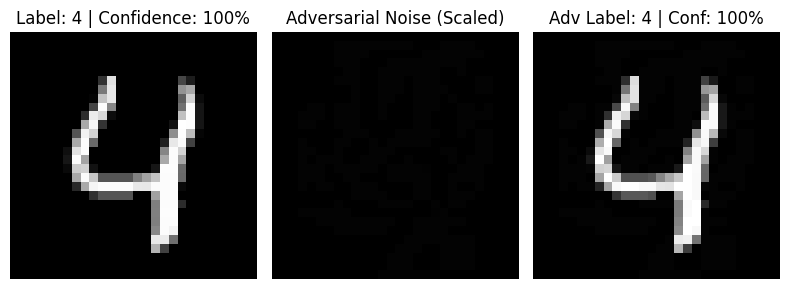

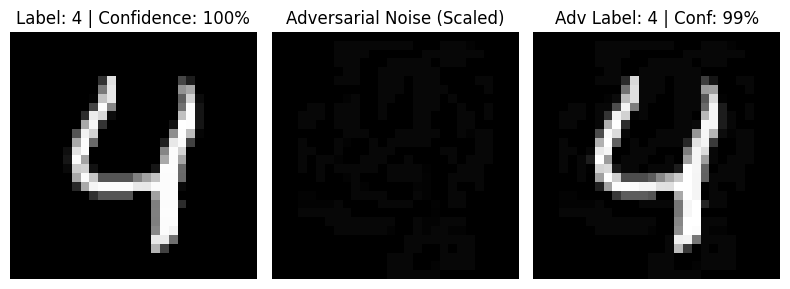

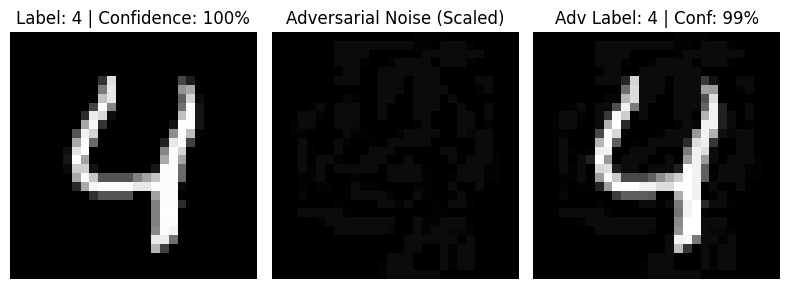

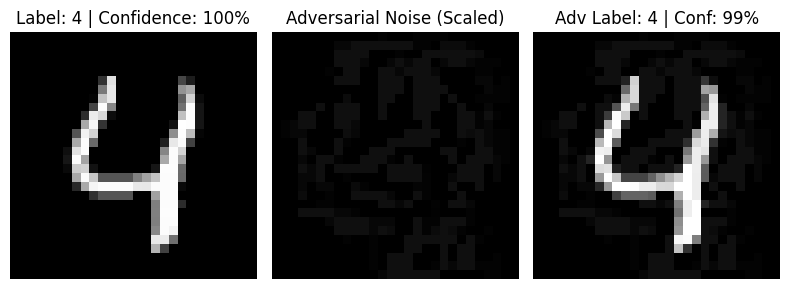

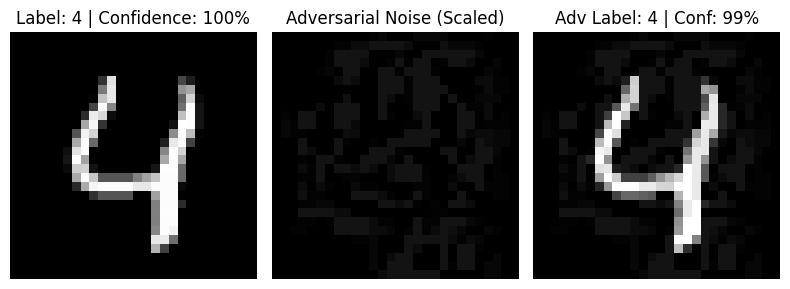

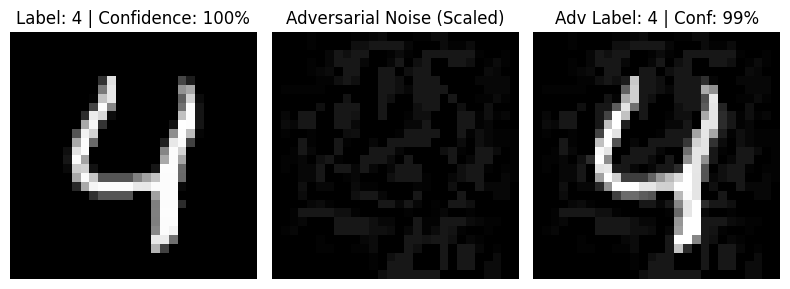

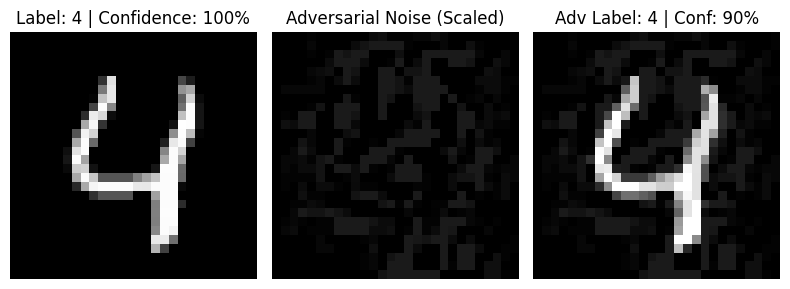

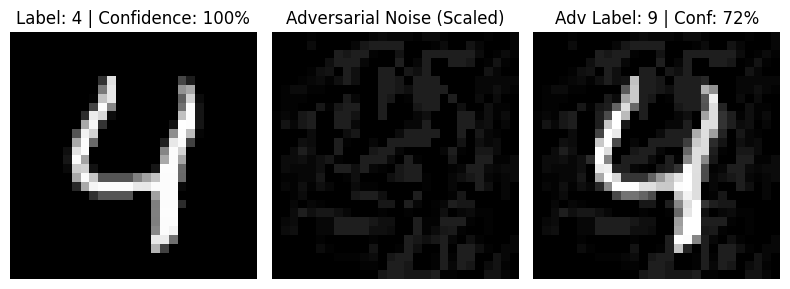

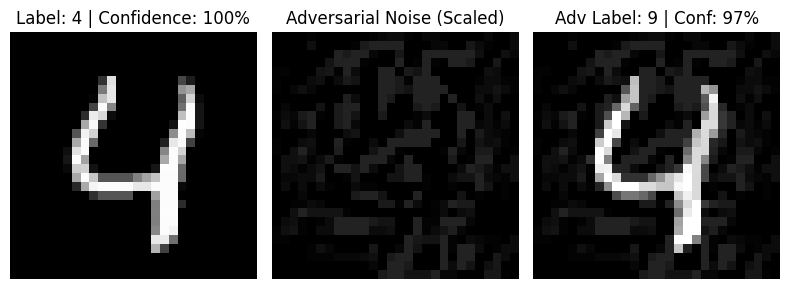

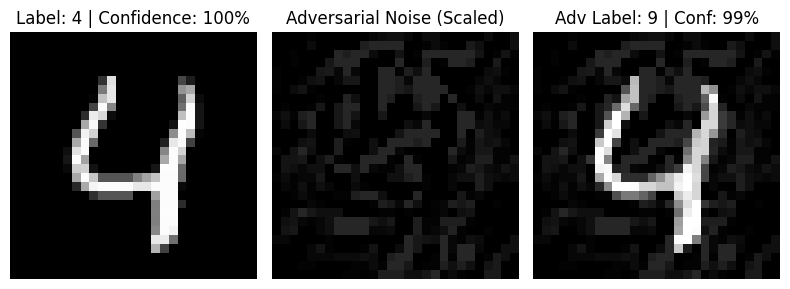

Final adversarial prediction: class 9, probabilities = [3.03314440e-09 1.43874895e-11 9.01401953e-10 2.46380849e-09
 3.49334488e-03 1.84373403e-06 3.15171633e-07 4.36829121e-14
 2.14498272e-04 9.96289968e-01]


In [142]:
adv_image, probs = create_plot_adversarial_images(model, original_img, label=9, epsilon=0.15, n_steps=10, targeted=True, return_probs=True)

final_adv_probs = probs[-1][2] 
pred_class = final_adv_probs.argmax()
print(f"Final adversarial prediction: class {pred_class}, probabilities = {final_adv_probs}")

Prediction of random image: 6


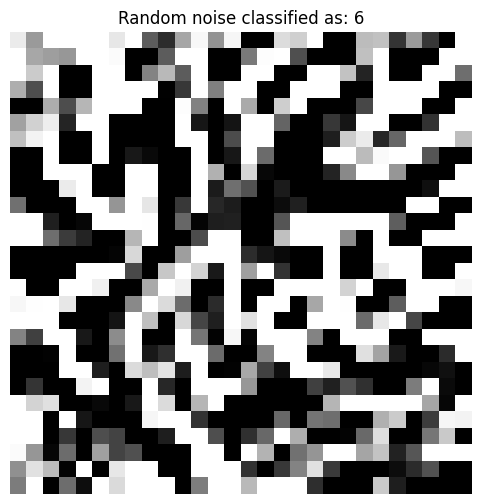

In [147]:
# Start from random noise
random_img = torch.randn((1, 1, 28, 28), device=device, requires_grad=True)

# Set optimizer for the noise
noise_optimizer = optim.Adam([random_img], lr=0.01)

target_class = 9

for step in range(300):
    noise_optimizer.zero_grad()
    output = model(random_img)
    loss = F.cross_entropy(output, torch.tensor([target_class]).to(device))
    (-loss).backward()  # maximize the probability of class 9
    noise_optimizer.step()

    # Clamp values to valid range
    random_img.data = torch.clamp(random_img.data, 0, 1)

# Predict
pred_noise = model(random_img).argmax(dim=1).item()
print(f'Prediction of random image: {pred_noise}')

# Plot
plt.figure(figsize=(6,6))
plt.title(f'Random noise classified as: {pred_noise}')
plt.imshow(random_img.squeeze().detach().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()
